In [4]:
import torch
import torch.nn as nn
# import fedAvg
from torchvision import datasets, transforms
from lenet5 import LeNet
from datetime import datetime

# check for cuda
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# parameters
EPOCHS = 100
LEARNING_RATE = 1e-3 
BATCH_SIZE = 32
#N_CLIENTS = 3

In [5]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for X, y_target in train_loader:
        
        # set gradient to zero
        optimizer.zero_grad()

        # if there is a GPU

        X = X.to(device)
        y_target =y_target.to(device)

        # prediction

        # call model forward()
        y_predict, _ = model(X)
        # get loss
        loss = criterion(y_predict, y_target)
        running_loss += loss.item() * X.size(0)
        
        # adjusting weights
        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def test(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for X, y_target in valid_loader:
        # if there is a GPU

        X = X.to(device)
        y_target = y_target.to(device)

        # prediction and loss

        # call model forward()
        y_predict, _ = model(X)
        # get loss
        loss = criterion(y_predict, y_target)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


def training_loop(model, criterion, optimizer, train_loader, test_loader,
                epochs, device, print_every=1):

    train_losses = []
    valid_losses = []

    train_accuracies = []
    valid_accuracies = []

    # train model
    for epoch in range(epochs):
        model, optimizer, train_loss = train(train_loader, model,
                                criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation

        # disable gradient calculation to save memory
        with torch.no_grad():
            model, valid_loss = test(test_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            train_acc = get_accuracy(model, train_loader, device)
            test_acc = get_accuracy(model, test_loader, device)

            train_accuracies.append(train_acc)
            valid_accuracies.append(test_acc)

            print(f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * test_acc:.2f}')

    return model, optimizer, (train_losses, valid_losses), (train_accuracies, valid_accuracies)

In [6]:
# Image augmentation 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalizing the test images
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Loading CIFAR10 using torchvision.datasets
#traindata = datasets.CIFAR10('./data', train=True, download=False,
#                       transform= transform_train)
traindata = datasets.CIFAR10('./data', train=True, download=True, 
                transform=transform_train)


# # Dividing the training data into num_clients, with each client having equal number of images
# traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] 
#                     / num_clients) for _ in range(num_clients)])
# Creating a pytorch loader for a Deep Learning model
train_loader = torch.utils.data.DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True) 

# Loading the test iamges and thus converting them into a test_loader
test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./data', train=False, 
            transform=transforms.Compose([transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
            ), batch_size=BATCH_SIZE, shuffle=True)
          

170499072it [04:47, 593800.65it/s]                                


Extracting ./data/cifar-10-python.tar.gz to ./data


In [7]:
model = LeNet().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
#criterion = nn.nll_loss()

model, optimizer, (train_losses, valid_losses), (train_accuracies, valid_accuracies) = training_loop(model, criterion, optimizer,
                        train_loader, test_loader, EPOCHS, DEVICE)


Epoch: 0	Train loss: 2.2838	Valid loss: 2.2432	Train accuracy: 18.70	Valid accuracy: 18.77
Epoch: 1	Train loss: 2.1710	Valid loss: 2.0598	Train accuracy: 25.08	Valid accuracy: 26.95
Epoch: 2	Train loss: 2.0148	Valid loss: 1.9347	Train accuracy: 28.20	Valid accuracy: 30.15
Epoch: 3	Train loss: 1.9293	Valid loss: 1.8440	Train accuracy: 31.05	Valid accuracy: 33.74
Epoch: 4	Train loss: 1.8478	Valid loss: 1.7446	Train accuracy: 34.30	Valid accuracy: 37.25
Epoch: 5	Train loss: 1.7667	Valid loss: 1.6756	Train accuracy: 36.72	Valid accuracy: 39.03
Epoch: 6	Train loss: 1.7007	Valid loss: 1.6056	Train accuracy: 38.47	Valid accuracy: 40.43
Epoch: 7	Train loss: 1.6476	Valid loss: 1.5597	Train accuracy: 40.37	Valid accuracy: 42.29
Epoch: 8	Train loss: 1.6082	Valid loss: 1.5146	Train accuracy: 41.42	Valid accuracy: 44.94
Epoch: 9	Train loss: 1.5721	Valid loss: 1.4812	Train accuracy: 43.24	Valid accuracy: 46.59
Epoch: 10	Train loss: 1.5502	Valid loss: 1.4618	Train accuracy: 44.15	Valid accuracy: 46.2

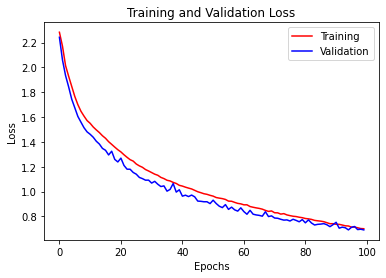

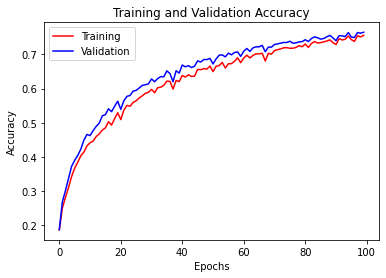

In [18]:
import matplotlib
import matplotlib.pyplot as plt

# Plotting Accuracy and Loss

SAVE_PLOTS = False# To save plots or show them
if SAVE_PLOTS:
    matplotlib.use("Agg") 

# Plot Loss 
plt.figure()
plt.title("Training and Validation Loss")
plt.plot(range(len(train_losses)), train_losses, color="r", label="Training")
plt.plot(range(len(valid_losses)), valid_losses, color="b", label="Validation")
plt.legend(loc="best")
plt.ylabel("Loss")
plt.xlabel("Epochs")
if SAVE_PLOTS:
    plt.savefig("plots/centralised_LR[{}]_EPOCHS[{}]_loss.png".format(LEARNING_RATE, EPOCHS)) 
else:
    plt.show()

# Plot Accuracy
plt.figure()
plt.title("Training and Validation Accuracy")
plt.plot(range(len(train_accuracies)), train_accuracies, color="r", label="Training")
plt.plot(range(len(valid_accuracies)), valid_accuracies, color="b", label="Validation")
plt.legend(loc="best")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
if SAVE_PLOTS:
    plt.savefig("plots/centralised_LR[{}]_EPOCHS[{}]_accuracy.png".format(LEARNING_RATE, EPOCHS))
else:
    plt.show()